In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install SimpleITK

     |████████████████████████████████| 48.4 MB 33 kB/s 


In [6]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob
import scipy.misc
import cv2

##import SimpleITK as sitk

from PIL import Image

#from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [7]:
annotations = pd.read_csv('/content/drive/My Drive/Dataset_LUNA_16/annotations.csv')
candidates = pd.read_csv('/content/drive/My Drive/Dataset_LUNA_16/candidates.csv')

In [8]:
annotations.head()

seriesuid  ...  diameter_mm
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...     5.651471
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  ...     4.224708
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...  ...     5.786348
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  ...     8.143262
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  ...    18.545150

[5 rows x 5 columns]

In [9]:
candidates['class'].sum()

1351

In [10]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [11]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [12]:
malignantCand = candidates[candidates['class']==1].index  
benignCand = candidates[candidates['class']==0].index

In [13]:
benignCand

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            551055, 551056, 551057, 551058, 551059, 551060, 551061, 551062,
            551063, 551064],
           dtype='int64', length=549714)

In [14]:
malignantCand

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [15]:
np.random.seed(42)
benignIndexes = np.random.choice(benignCand, len(malignantCand)*5, replace = False)

In [16]:
candidatesDf = candidates.iloc[list(malignantCand)+list(benignIndexes)]

In [17]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.30, random_state = 42)

In [19]:
print('number of positive cases are ' + str(y_train.sum()))
print('total set size is ' + str(len(y_train)))
print('percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train)))

number of positive cases are 628
total set size is 3971
percentage of positive cases are 0.15814656257869555


In [20]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print(len(X_train_new), len(y_train_new))

5227 5227


In [21]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/drive/My Drive/Dataset_LUNA_16/data/train/image_269021.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_124471.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_333859.jpg',
       ...,
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_2403172.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_2473694.jpg',
       '/content/drive/My Drive/Dataset_LUNA_16/data/train/image_2372119.jpg'],
      dtype='<U68')

In [22]:
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [23]:
!pip install tflearn 

     |████████████████████████████████| 107 kB 12.8 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=8914a6697e5698a7ebf1599f5336771fb02f8484634b276db259573d960fa337
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [24]:
import tflearn
from tflearn.data_utils import build_hdf5_image_dataset

Instructions for updating:
non-resource variables are not supported in the long term


In [25]:
dataset_file

'traindatalabels.txt'

In [26]:
# build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)

In [27]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('/content/drive/My Drive/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/drive/My Drive/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [28]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [29]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

In [30]:
X_val_images

<HDF5 dataset "X": shape (1297, 50, 50), type "<f4">

In [31]:
Y_val_labels

<HDF5 dataset "Y": shape (1297, 2), type "<f4">

In [32]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)

In [33]:
print(X_train_processing.shape)
print(X_val_processing.shape)

(5187, 50, 50)
(1297, 50, 50)


In [34]:
print(X_train_processing.dtype)
print(X_val_processing.dtype)

float32
float32


In [35]:
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

In [36]:
img_test = X_train_processing[100]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [37]:
print(Y_train_labels[100])

[1. 0.]


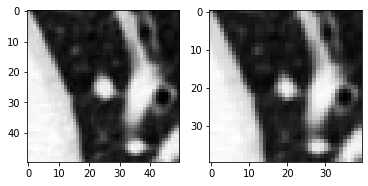

In [38]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled,cmap='gray')

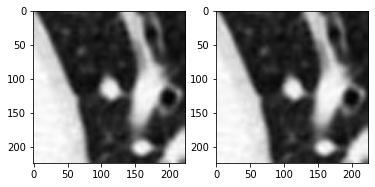

In [39]:
img_test_subtracted_mean = PreProcessing(img_test_upsampled).subtract_mean()
plt.subplot(121)
plt.imshow(img_test_upsampled,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_subtracted_mean,cmap='gray')

In [40]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [41]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [42]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


In [43]:
h5f2 = h5py.File('/content/drive/My Drive/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [44]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [46]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.1))
    
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))

	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
    
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
    
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
    
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'));return model

mobile = define_model()

Instructions for updating:
Colocations handled automatically by placer.


In [47]:
mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0

In [48]:
op_layer = mobile.output
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(op_layer)
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(final_layer)
final_layer = Dense(2,activation= 'softmax')(final_layer)

from keras.models  import Model
# Define model input and output

model = Model(inputs = mobile.input , outputs = final_layer)
import keras
optimizer_sgd = keras.optimizers.adam_v2.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 64)        256   

In [50]:
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["acc"])
	plt.plot(hist.history['val_acc'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

In [51]:
import keras
callbacks = [
    keras.callbacks.ModelCheckpoint('Initial_Model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau()]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/100
81/81 [==============================] - ETA: 0s - batch: 40.0000 - size: 63.2469 - loss: 0.4877 - acc: 0.8319

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


81/81 [==============================] - 34s 50ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.4877 - acc: 0.8319 - val_loss: 0.4797 - val_acc: 0.8273 - lr: 0.0010
Epoch 2/100
81/81 [==============================] - 4s 48ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.4453 - acc: 0.8376 - val_loss: 0.4402 - val_acc: 0.8273 - lr: 0.0010
Epoch 3/100
81/81 [==============================] - 4s 48ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.4376 - acc: 0.8358 - val_loss: 0.4484 - val_acc: 0.8288 - lr: 0.0010
Epoch 4/100
81/81 [==============================] - 4s 49ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.4200 - acc: 0.8370 - val_loss: 0.4262 - val_acc: 0.8319 - lr: 0.0010
Epoch 5/100
81/81 [==============================] - 4s 49ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.4154 - acc: 0.8347 - val_loss: 0.4147 - val_acc: 0.8319 - lr: 0.0010
Epoch 6/100
81/81 [==============================] - 4s 49ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.4039 - acc: 

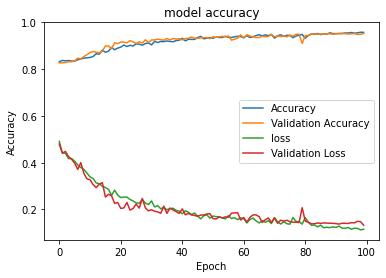

In [52]:
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
	steps = int(X_train_images_np.shape[0] / 64)
	hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=100, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)
	# evaluate model
	_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('Accuracy> %.3f' % (acc * 100.0))
  
 
	# learning curves
	summarize_diagnostics(hist)

# entry point, run the test harness
run_test_harness()

In [53]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model.predict(X_test_images_np)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_labels_np,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


confusion matrix
[[1314   26]
 [  38  244]]


In [54]:
#Second Model

In [55]:
def define_model_2():
  model2 = Sequential()
  model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D((2, 2)))
  model2.add(Dropout(0.1))
  model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D((2, 2)))
  model2.add(Dropout(0.2))

  model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D((2, 2)))
  model2.add(Dropout(0.3))

  model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D((2, 2)))
  model2.add(Dropout(0.4))
    
  model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D((2, 2)))
  model2.add(Dropout(0.5))
  model2.add(Flatten())
    
  model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model2.add(BatchNormalization())
  model2.add(Dropout(0.5))
  model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'));return model2

mobile2 = define_model_2()

In [56]:
mobile2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)       

In [57]:
op_layer = mobile2.output
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(op_layer)
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(final_layer)
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(final_layer)
final_layer = Dense(2,activation= 'softmax')(final_layer)

from keras.models  import Model
# Define model input and output

model2 = Model(inputs = mobile2.input , outputs = final_layer)
import keras
optimizer_sgd = keras.optimizers.adam_v2.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer_sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 25, 25, 64)        256 

In [59]:
import keras
callbacks_2 = [
    keras.callbacks.ModelCheckpoint('Second_Model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau()]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/100
81/81 [==============================] - 4s 45ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.1217 - acc: 0.9526 - val_loss: 0.1414 - val_acc: 0.9499 - lr: 1.0000e-04
Epoch 2/100
81/81 [==============================] - 4s 50ms/step - batch: 40.0000 - size: 63.2469 - loss: 0.1205 - acc: 0.9553 - val_loss: 0.1396 - val_acc: 0.9530 - lr: 1.0000e-04
Epoch 3/100
81/81 [==============================] - 4s 49ms/step - batch: 40.0000 - size: 64.0000 - loss: 0.1182 - acc: 0.9572 - val_loss: 0.1377 - val_acc: 0.9530 - lr: 1.0000e-04
Epoch 4/100
81/81 [==============================] - 4s 48ms/step - batch: 40.0000 - size: 62.4938 - loss: 0.1209 - acc: 0.9563 - val_loss: 0.1389 - val_acc: 0.9514 - lr: 1.0000e-04
Epoch 5/100
81/81 [==============================] - 4s 48ms/step - batch: 40.0000 - size: 64.0000 - loss: 0.1216 - acc: 0.9535 - val_loss: 0.1398 - val_acc: 0.9507 - lr: 1.0000e-04
Epoch 6/100
81/81 [==============================] - 4s 46ms/step - batch: 40.0000 - size:

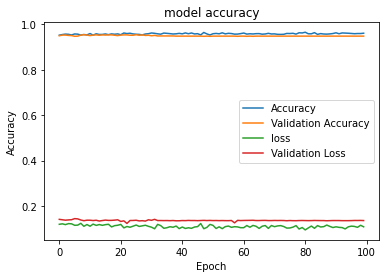

In [60]:
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
	steps = int(X_train_images_np.shape[0] / 64)
	hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=100, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks_2)
	# evaluate model
	_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist)

# entry point, run the test harness
run_test_harness()